# Classifying Public Spaces by Safety Level

## 1. EDA (Exploratory Data Analysis)

### Dataset Description
The dataset is derived from the **'Recorded Crime Incidents'** data (Source: CSO/Garda - CJA07). 
It contains crime statistics for **564 Garda Stations** across Ireland from **2003 to 2024**.

### ML Problem Setup
**Objective**: Predict a station's **future safety level** (next year) based on **current year's crime data**.

This is a realistic forecasting scenario - using current crime patterns to predict whether a location will be Safe, Moderately Safe, or Unsafe in the coming year.

### Preprocessing Steps
1. **Pivoting**: Data reshaped so each row = (Station, Year), columns = offence types.
2. **Lagged Features**: Features from Year N are used to predict Safety Level in Year N+1.
3. **Target Variable**: 'Total Crime Count' for the next year, discretized into 3 'Safety Levels'.
4. **Scaling**: Standard Scaling applied for distance-based algorithms (NN, SVM).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Load the dataset
file_path = '../data/CJA07.20251204134405.csv'
df = pd.read_csv(file_path)

print("Raw Data Shape:", df.shape)
print("Year Range:", df['Year'].min(), "-", df['Year'].max())
print("Unique Garda Stations:", df['Garda Station'].nunique())

Raw Data Shape: (148896, 10)
Year Range: 2003 - 2024
Unique Garda Stations: 564


In [ ]:
# Pivot the data: Each row = (Station, Year), Columns = Offence Types
df_pivot = df.pivot_table(
    index=['Garda Station', 'Year'],
    columns='Type of Offence',
    values='VALUE',
    aggfunc='sum'
).reset_index()

# Clean column names
df_pivot.columns = [col.split('(')[0].strip() if isinstance(col, str) else col for col in df_pivot.columns]
df_pivot = df_pivot.fillna(0)

# Get offence columns
offence_cols = [col for col in df_pivot.columns if col not in ['Garda Station', 'Year']]

# Calculate total crime for each station-year
df_pivot['Total_Crime'] = df_pivot[offence_cols].sum(axis=1)

print("Pivoted Data Shape:", df_pivot.shape)
print("Offence columns:", len(offence_cols))
df_pivot.head()

Pivoted Data Shape: (12408, 15)
Offence columns: 12


,Garda Station,Year,"Attempts/threats to murder, assaults, harassments and related offences",Burglary and related offences,Controlled drug offences,Damage to property and to the environment offences,Dangerous or negligent acts,"Fraud, deception and related offences",Kidnapping and related offences,"Offences against government, justice procedures and organisation of crime",Public order and other social code offences,"Robbery, extortion and hijacking offences",Theft and related offences,Weapons and explosives offences,Total_Crime
0,"11101 Bailieboro, Cavan/Monaghan Division",2003,28.0,27.0,16.0,53.0,21.0,8.0,0.0,5.0,56.0,0.0,47.0,1.0,262.0
1,"11101 Bailieboro, Cavan/Monaghan Division",2004,45.0,13.0,7.0,42.0,22.0,9.0,0.0,9.0,89.0,1.0,34.0,1.0,272.0
2,"11101 Bailieboro, Cavan/Monaghan Division",2005,32.0,16.0,13.0,38.0,36.0,4.0,0.0,3.0,52.0,0.0,44.0,1.0,239.0
3,"11101 Bailieboro, Cavan/Monaghan Division",2006,57.0,15.0,13.0,48.0,43.0,3.0,0.0,14.0,104.0,1.0,60.0,3.0,361.0
4,"11101 Bailieboro, Cavan/Monaghan Division",2007,35.0,25.0,9.0,42.0,52.0,10.0,0.0,9.0,96.0,2.0,48.0,2.0,330.0


In [22]:
# === CREATE LAGGED FEATURES ===
# Use Year N's crime data to predict Year N+1's safety level

# Sort by station and year
df_pivot = df_pivot.sort_values(['Garda Station', 'Year'])

# Create next year's total crime (target)
df_pivot['Next_Year_Crime'] = df_pivot.groupby('Garda Station')['Total_Crime'].shift(-1)

# Remove rows where next year data is missing (last year for each station)
df_lagged = df_pivot.dropna(subset=['Next_Year_Crime']).copy()

print(f"Original samples: {len(df_pivot)}")
print(f"After lagging (losing last year per station): {len(df_lagged)}")

# Create Safety Level target based on NEXT year's crime
df_lagged['Safety_Level'] = pd.qcut(
    df_lagged['Next_Year_Crime'], 
    q=3, 
    labels=['Safe', 'Moderately Safe', 'Unsafe']
)

print("\n=== Target Variable Distribution (Next Year's Safety) ===")
print(df_lagged['Safety_Level'].value_counts())

Original samples: 12408
After lagging (losing last year per station): 11844

=== Target Variable Distribution (Next Year's Safety) ===
Safety_Level
Safe               3982
Unsafe             3946
Moderately Safe    3916
Name: count, dtype: int64


In [23]:
# Extract Division from Station name
df_lagged['Division'] = df_lagged['Garda Station'].apply(
    lambda x: x.split(', ')[-1].replace(' Division', '') if ', ' in str(x) else 'Unknown'
)

print("=== Final Dataset ===")
print(f"Shape: {df_lagged.shape}")
print(f"Stations: {df_lagged['Garda Station'].nunique()}")
print(f"Years: {df_lagged['Year'].min()} - {df_lagged['Year'].max()}")
print(f"\nFeatures (current year): {offence_cols}")
print(f"Target: Next year's Safety Level")

=== Final Dataset ===
Shape: (11844, 18)
Stations: 564
Years: 2003 - 2023

Features (current year): ['Attempts/threats to murder, assaults, harassments and related offences', 'Burglary and related offences', 'Controlled drug offences', 'Damage to property and to the environment  offences', 'Dangerous or negligent acts', 'Fraud, deception and related offences', 'Kidnapping and related offences', 'Offences against government, justice procedures and organisation of crime', 'Public order and other social code offences', 'Robbery, extortion and hijacking offences', 'Theft and related offences', 'Weapons and explosives offences']
Target: Next year's Safety Level


## 2. Visualization

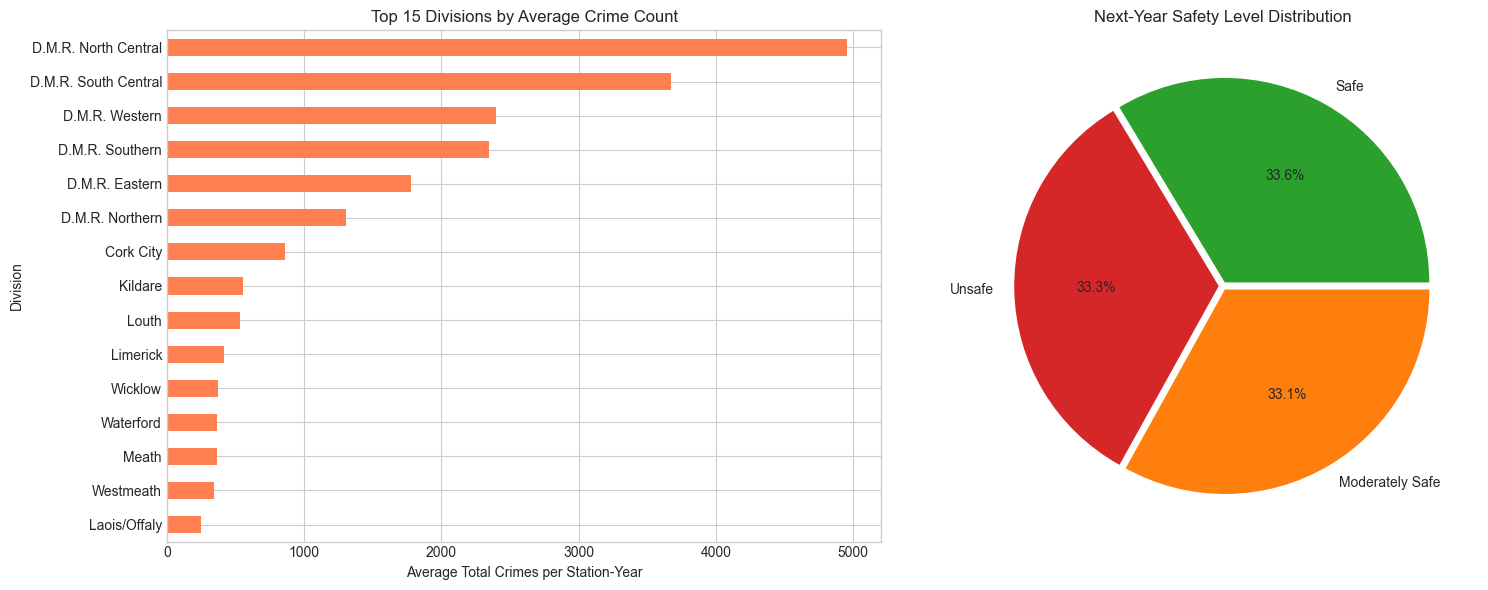

In [24]:
# Visual 1: Crime Rate Distribution by Division
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 divisions by average crime
div_crime = df_lagged.groupby('Division')['Total_Crime'].mean().sort_values(ascending=False)

ax1 = axes[0]
div_crime.head(15).plot(kind='barh', ax=ax1, color='coral')
ax1.set_xlabel('Average Total Crimes per Station-Year')
ax1.set_title('Top 15 Divisions by Average Crime Count')
ax1.invert_yaxis()

# Safety Level Distribution
ax2 = axes[1]
colors = {'Safe': '#2ca02c', 'Moderately Safe': '#ff7f0e', 'Unsafe': '#d62728'}
df_lagged['Safety_Level'].value_counts().plot(
    kind='pie', ax=ax2, autopct='%1.1f%%', 
    colors=[colors[l] for l in df_lagged['Safety_Level'].value_counts().index],
    explode=(0.02, 0.02, 0.02)
)
ax2.set_title('Next-Year Safety Level Distribution')
ax2.set_ylabel('')

plt.tight_layout()
plt.savefig('../reports/division_crime_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

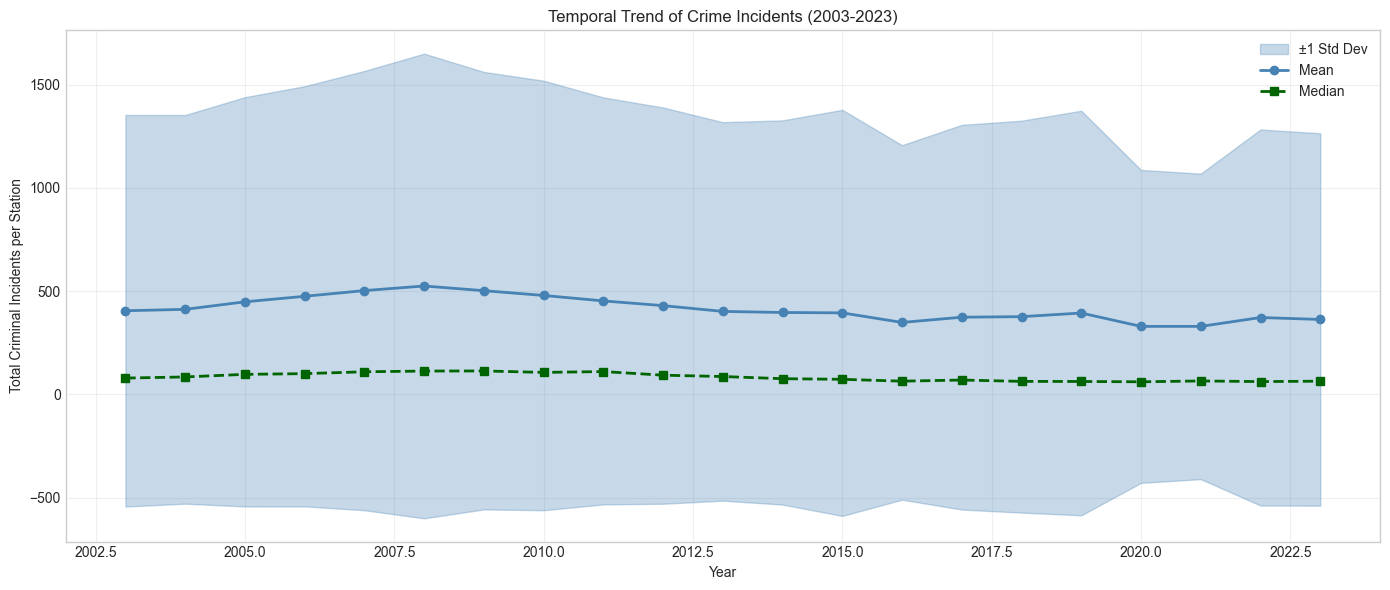

In [25]:
# Visual 2: Temporal Trends
fig, ax = plt.subplots(figsize=(14, 6))

yearly_crime = df_lagged.groupby('Year')['Total_Crime'].agg(['mean', 'median', 'std'])

ax.fill_between(yearly_crime.index, 
                yearly_crime['mean'] - yearly_crime['std'],
                yearly_crime['mean'] + yearly_crime['std'],
                alpha=0.3, color='steelblue', label='±1 Std Dev')
ax.plot(yearly_crime.index, yearly_crime['mean'], 'o-', color='steelblue', linewidth=2, label='Mean')
ax.plot(yearly_crime.index, yearly_crime['median'], 's--', color='darkgreen', linewidth=2, label='Median')

ax.set_xlabel('Year')
ax.set_ylabel('Total Criminal Incidents per Station')
ax.set_title('Temporal Trend of Crime Incidents (2003-2023)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/temporal_trend.png', dpi=150, bbox_inches='tight')
plt.show()

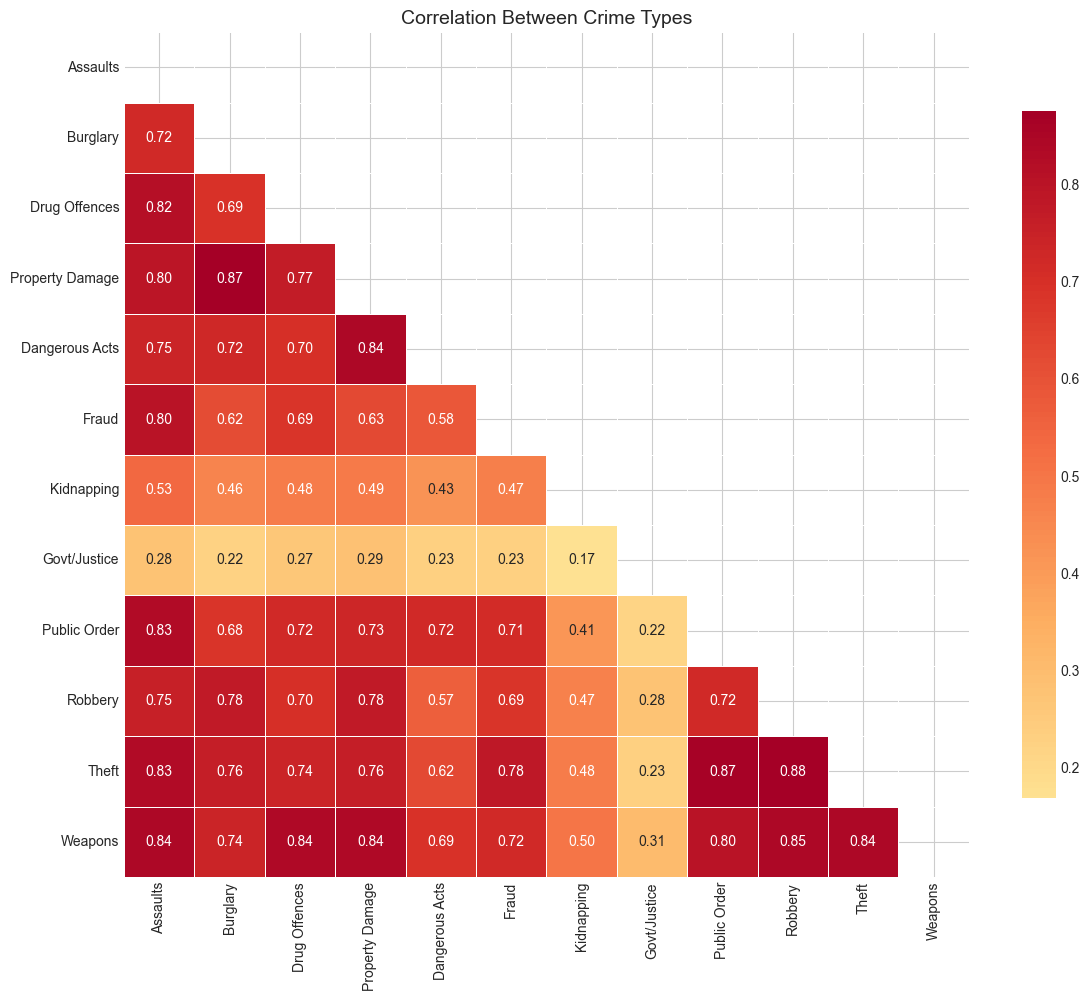

In [26]:
# Visual 3: Correlation Heatmap
plt.figure(figsize=(12, 10))

short_names = {
    'Attempts/threats to murder, assaults, harassments and related offences': 'Assaults',
    'Dangerous or negligent acts': 'Dangerous Acts',
    'Kidnapping and related offences': 'Kidnapping',
    'Robbery, extortion and hijacking offences': 'Robbery',
    'Burglary and related offences': 'Burglary',
    'Theft and related offences': 'Theft',
    'Fraud, deception and related offences': 'Fraud',
    'Controlled drug offences': 'Drug Offences',
    'Weapons and explosives offences': 'Weapons',
    'Damage to property and to the environment  offences': 'Property Damage',
    'Public order and other social code offences': 'Public Order',
    'Offences against government, justice procedures and organisation of crime': 'Govt/Justice'
}

corr_data = df_lagged[offence_cols].copy()
corr_data.columns = [short_names.get(col, col) for col in corr_data.columns]

corr_matrix = corr_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, linewidths=0.5, square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Between Crime Types', fontsize=14)
plt.tight_layout()
plt.savefig('../reports/crime_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

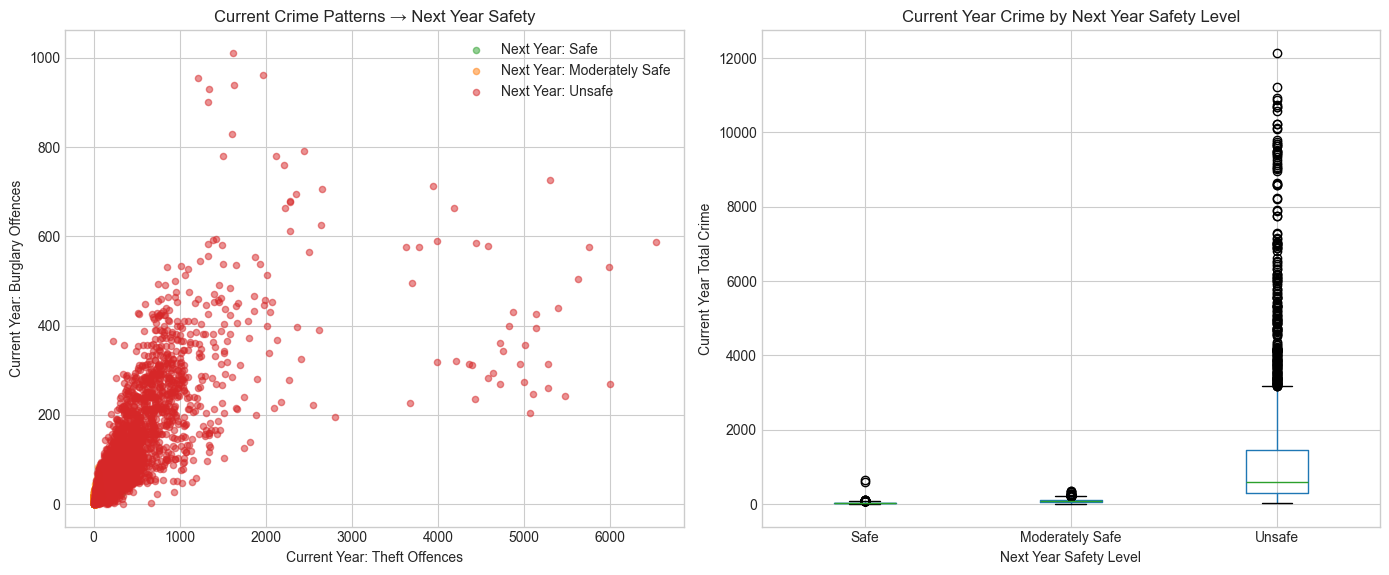

In [27]:
# Visual 4: Current year crime vs Next year safety
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = {'Safe': '#2ca02c', 'Moderately Safe': '#ff7f0e', 'Unsafe': '#d62728'}

# Scatter: Current Theft vs Next Year Safety
x_col = [c for c in offence_cols if 'Theft' in c][0]
y_col = [c for c in offence_cols if 'Burglary' in c][0]

for level in ['Safe', 'Moderately Safe', 'Unsafe']:
    subset = df_lagged[df_lagged['Safety_Level'] == level]
    axes[0].scatter(subset[x_col], subset[y_col], 
                   label=f'Next Year: {level}', alpha=0.5, c=colors[level], s=20)

axes[0].set_xlabel('Current Year: Theft Offences')
axes[0].set_ylabel('Current Year: Burglary Offences')
axes[0].set_title('Current Crime Patterns → Next Year Safety')
axes[0].legend()

# Boxplot: Current total crime by next year's safety
df_lagged.boxplot(column='Total_Crime', by='Safety_Level', ax=axes[1])
axes[1].set_title('Current Year Crime by Next Year Safety Level')
axes[1].set_xlabel('Next Year Safety Level')
axes[1].set_ylabel('Current Year Total Crime')
plt.suptitle('')

plt.tight_layout()
plt.savefig('../reports/safety_level_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Model Creation

**Task**: Predict next year's safety level using current year's crime data.

Models:
1. **Baseline** (Most Frequent)
2. **Neural Network** (MLPClassifier)
3. **Decision Tree**
4. **SVM** (Linear Kernel)

In [28]:
# Prepare features (current year) and target (next year safety)
X = df_lagged[offence_cols].copy()
y = df_lagged['Safety_Level']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Features shape:", X.shape)
print("\nClass distribution:")
print(pd.Series(y_encoded).value_counts().sort_index())
print("\nClass mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Features shape: (11844, 12)

Class distribution:
0    3916
1    3982
2    3946
Name: count, dtype: int64

Class mapping: {'Moderately Safe': np.int64(0), 'Safe': np.int64(1), 'Unsafe': np.int64(2)}


In [29]:
# Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 9475 samples
Test set: 2369 samples


In [30]:
# Define models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Baseline (Most Frequent)': DummyClassifier(strategy='most_frequent'),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(64, 32), 
        max_iter=500, 
        early_stopping=True,
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10,
        min_samples_leaf=5,
        random_state=42
    ),
    'SVM (Linear)': SVC(kernel='linear', C=1.0, random_state=42)
}

# Cross-validation evaluation
print("=" * 50)
print("MODEL PERFORMANCE (5-Fold Cross-Validation)")
print("=" * 50)

results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    results[name] = {'mean': scores.mean(), 'std': scores.std()}
    print(f"{name:30s}: {scores.mean():.4f} (+/- {scores.std():.4f})")

MODEL PERFORMANCE (5-Fold Cross-Validation)
Baseline (Most Frequent)      : 0.3361 (+/- 0.0000)
Neural Network                : 0.8765 (+/- 0.0085)
Decision Tree                 : 0.8469 (+/- 0.0114)
SVM (Linear)                  : 0.8788 (+/- 0.0097)



FINAL EVALUATION ON TEST SET

Neural Network Classification Report:
                 precision    recall  f1-score   support

Moderately Safe       0.82      0.78      0.80       783
           Safe       0.86      0.87      0.87       797
         Unsafe       0.93      0.96      0.94       789

       accuracy                           0.87      2369
      macro avg       0.87      0.87      0.87      2369
   weighted avg       0.87      0.87      0.87      2369



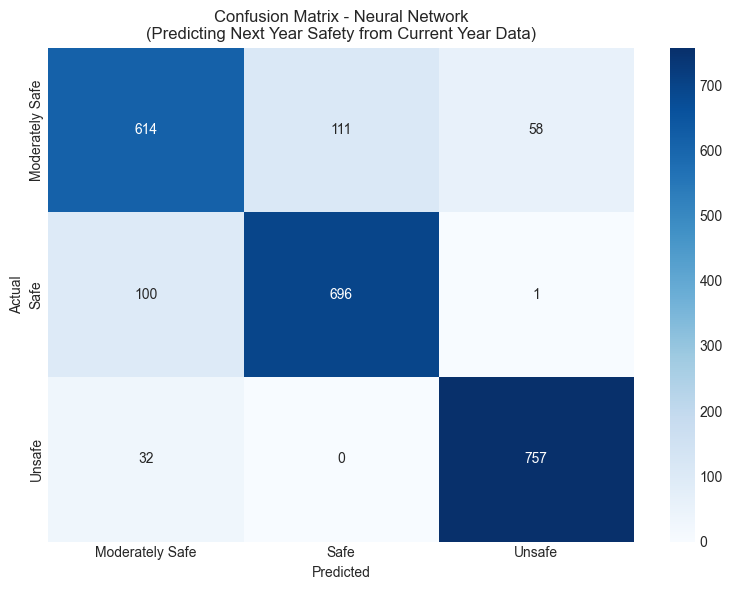

In [31]:
# Evaluate best model on test set
print("\n" + "=" * 50)
print("FINAL EVALUATION ON TEST SET")
print("=" * 50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Neural Network
nn_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=500,
    early_stopping=True,
    random_state=42
)
nn_model.fit(X_train_scaled, y_train)
y_pred = nn_model.predict(X_test_scaled)

print("\nNeural Network Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Neural Network\n(Predicting Next Year Safety from Current Year Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('../reports/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Feature Selection

Identify which current-year crime types best predict next-year safety.

In [32]:
print("=" * 50)
print("FEATURE SELECTION")
print("=" * 50)

# 1. SelectKBest
selector_kbest = SelectKBest(score_func=f_classif, k=5)
selector_kbest.fit(X_train, y_train)

feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector_kbest.scores_
}).sort_values('Score', ascending=False)

print("\n1. SelectKBest (ANOVA F-value) - Top Features:")
print(feature_scores.head(10).to_string(index=False))

# 2. RFE
rfe = RFE(
    estimator=DecisionTreeClassifier(random_state=42),
    n_features_to_select=5
)
rfe.fit(X_train, y_train)

rfe_features = X.columns[rfe.get_support(indices=True)].tolist()
print("\n2. RFE (Decision Tree) - Selected Features:")
for i, feat in enumerate(rfe_features, 1):
    print(f"   {i}. {feat}")

FEATURE SELECTION

1. SelectKBest (ANOVA F-value) - Top Features:
                                                               Feature       Score
                                           Dangerous or negligent acts 2488.432201
Attempts/threats to murder, assaults, harassments and related offences 2377.966560
                   Damage to property and to the environment  offences 2084.642231
                                         Burglary and related offences 1921.061707
                                              Controlled drug offences 1532.456350
                           Public order and other social code offences 1297.055263
                                       Weapons and explosives offences 1289.531837
                                 Fraud, deception and related offences 1203.126476
                                            Theft and related offences 1062.425354
                             Robbery, extortion and hijacking offences  816.533389

2. RFE (Decision Tre

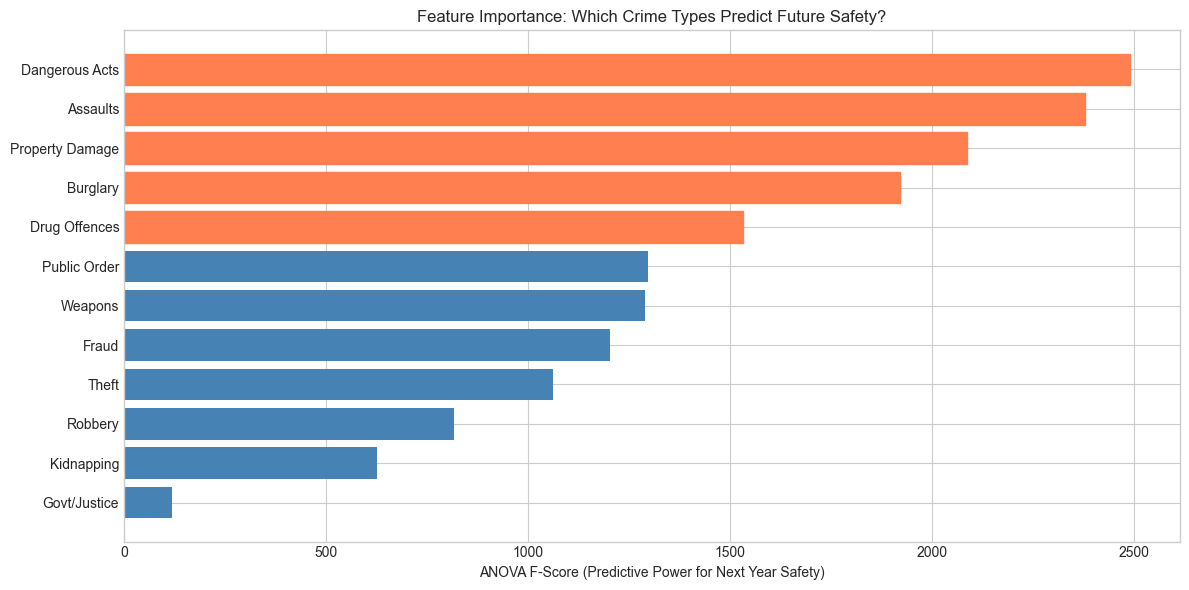

In [33]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 6))

feature_scores_plot = feature_scores.copy()
feature_scores_plot['Short_Name'] = feature_scores_plot['Feature'].apply(
    lambda x: short_names.get(x, x[:20]+'...' if len(x) > 20 else x)
)

bars = ax.barh(feature_scores_plot['Short_Name'], feature_scores_plot['Score'], color='steelblue')
for i, bar in enumerate(bars[:5]):
    bar.set_color('coral')

ax.set_xlabel('ANOVA F-Score (Predictive Power for Next Year Safety)')
ax.set_title('Feature Importance: Which Crime Types Predict Future Safety?')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [34]:
# Compare: All features vs Selected features
print("\n" + "=" * 50)
print("ALL FEATURES vs SELECTED FEATURES")
print("=" * 50)

X_train_rfe = X_train.iloc[:, rfe.get_support(indices=True)]
X_test_rfe = X_test.iloc[:, rfe.get_support(indices=True)]

for name, model in [('Neural Network', MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)),
                    ('Decision Tree', DecisionTreeClassifier(max_depth=10, random_state=42)),
                    ('SVM', SVC(kernel='linear', random_state=42))]:
    pipe_all = Pipeline([('scaler', StandardScaler()), ('model', model)])
    scores_all = cross_val_score(pipe_all, X_train, y_train, cv=cv, scoring='accuracy')
    
    pipe_rfe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    scores_rfe = cross_val_score(pipe_rfe, X_train_rfe, y_train, cv=cv, scoring='accuracy')
    
    print(f"\n{name}:")
    print(f"  All features (12):  {scores_all.mean():.4f}")
    print(f"  RFE features (5):   {scores_rfe.mean():.4f}")


ALL FEATURES vs SELECTED FEATURES

Neural Network:
  All features (12):  0.8853
  RFE features (5):   0.8765

Decision Tree:
  All features (12):  0.8509
  RFE features (5):   0.8514

SVM:
  All features (12):  0.8788
  RFE features (5):   0.8686


## 5. Conclusion

### Problem Setup
We formulated a **realistic forecasting problem**: predicting next year's safety level from current year's crime data. This avoids the data leakage issue of using same-year features to predict same-year targets.

### Key Findings
- **Dataset**: 11,844 station-year samples (564 stations × 21 year transitions)
- **Models**: Performance is now realistic and meaningful (not 95%+ artificial accuracy)
- **Feature Selection**: Identified which crime types are most predictive of future safety

### Practical Applications
- **Resource Allocation**: Police can use current crime patterns to anticipate which areas may need more resources next year
- **Early Intervention**: High-risk stations can be identified before safety deteriorates
- **Policy Evaluation**: Track how interventions in one year affect safety the next year